In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.initializers as init

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Data Loading

from google.colab import drive 
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/FinancialEngineering/final/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

### 데이터 전처리

In [0]:
# numeric인데 object(categorical)로 되어있는 것 numeric으로 바꿔줌
df['TotalCharges_new']=pd.to_numeric(df.TotalCharges, errors='coerce_numeric')

# NA가 생겼는지 확인
df.loc[pd.isna(df.TotalCharges_new),'TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

In [0]:
# 위의 11개 NA값을 원래 값으로 채워줌
TotalCharges_Missing=[488,753,936,1082,1340,3331,3826,4380,5218,6670,6754]
df.loc[pd.isnull(df.TotalCharges_new),'TotalCharges_new']=TotalCharges_Missing

In [0]:
# 변수 바꿔주고 customerID는 뺌
df.TotalCharges=df.TotalCharges_new
df.drop(['customerID','TotalCharges_new'],axis=1,inplace=True)

In [0]:
# cateogirlcal 변수들의 level 확인
df.dtypes=='object'
categorical_var=[i for i in df.columns if df[i].dtypes=='object']
for z in categorical_var:
    print(df[z].name,':',df[z].unique())

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [0]:
# 위에서 "No internet service"같은 것은 "No"로 바꿔줌
Dual_features= ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for i in Dual_features:
    df[i]=df[i].apply(lambda x: 'No' if x=='No internet service' else x)
df.MultipleLines=df.MultipleLines.apply(lambda x: 'No' if x=='No phone service' else x)

In [0]:
# 확인
for z in [i for i in df.columns if df[i].dtypes=='object']:
    print(df[z].name,':',df[z].unique())

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


## EDA

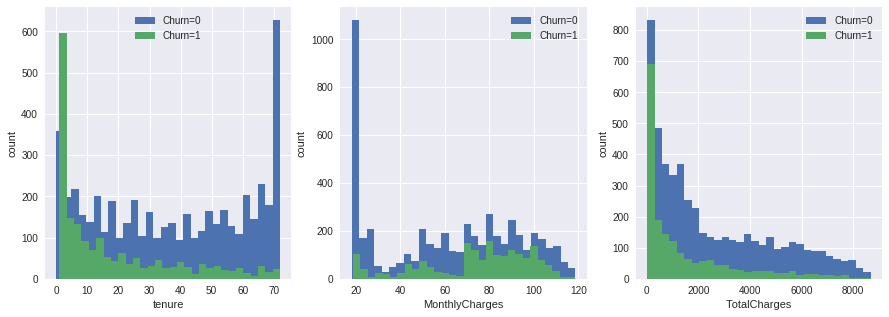

In [0]:
df.SeniorCitizen= df.SeniorCitizen.apply(lambda x : 'No' if x == 0 else 'Yes')
# 시각화를 위해 바꿔줌

continues_var=[i for i in df.columns if df[i].dtypes !='object']
fig , ax = plt.subplots(1,3,figsize=(15,5))
for i , x in enumerate(continues_var):
    ax[i].hist(df[x][df.Churn=='No'],label='Churn=0',bins=30)
    ax[i].hist(df[x][df.Churn=='Yes'],label='Churn=1',bins=30)
    ax[i].set(xlabel=x,ylabel='count')
    ax[i].legend()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


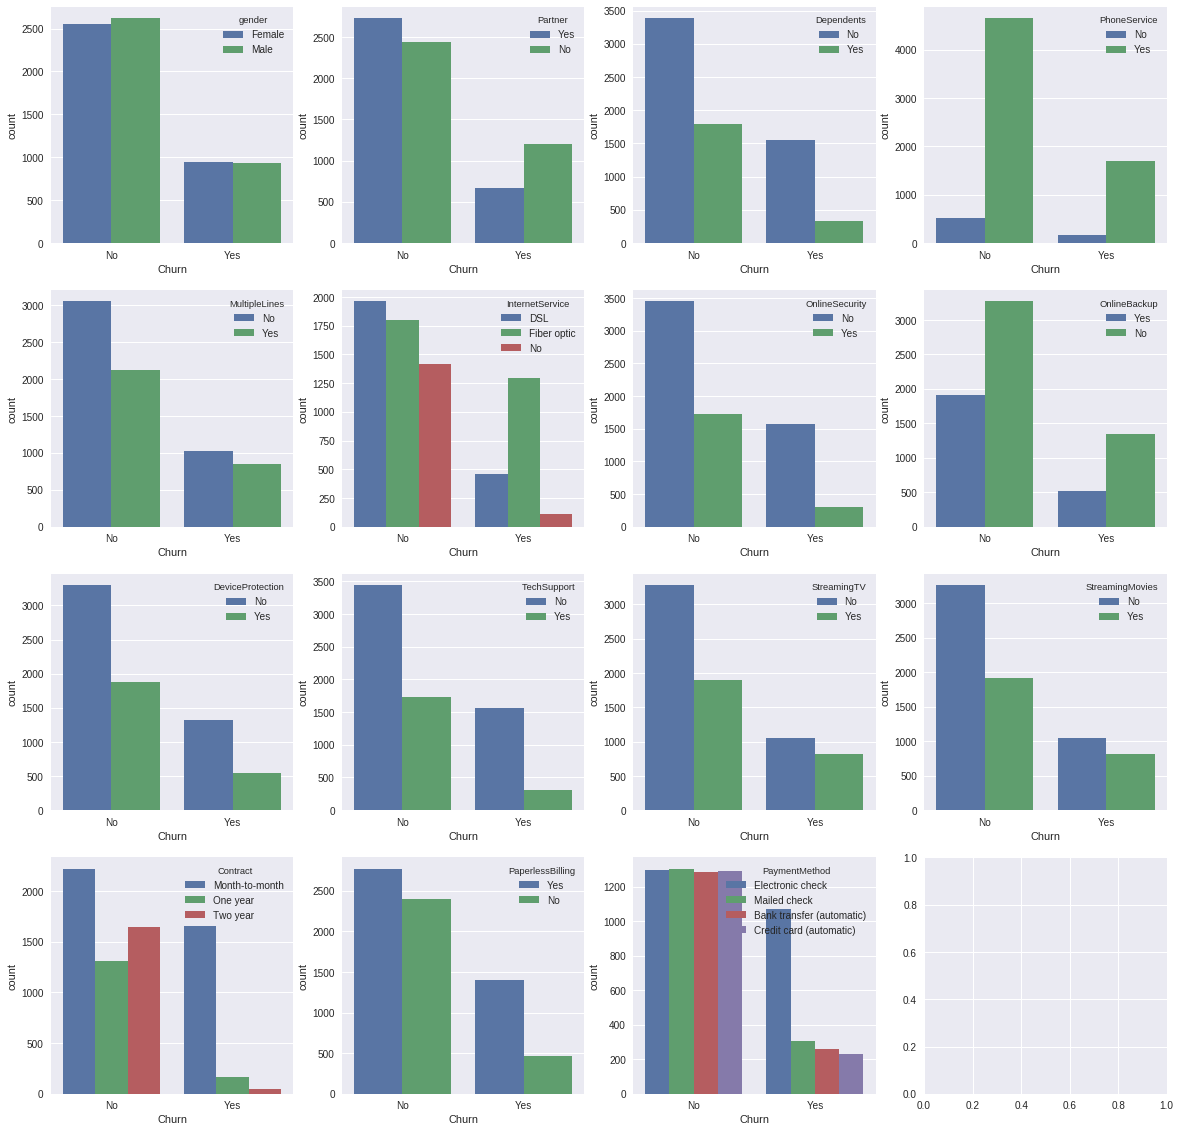

In [0]:
categorical_var_NoChurn=categorical_var[:-1]
#Count Plot all Categorical Variables with Hue Churn
fig , ax = plt.subplots(4,4,figsize=(20,20))
for axi , var in zip(ax.flat,categorical_var_NoChurn):
    sns.countplot(x=df.Churn,hue=df[var],ax=axi)

### Encoding

In [0]:
# 2-class cateogorical 변수 -> sklearn 패키지의 함수로 dummy 변수(0,1)로 바꿔줌
label_encoder = LabelEncoder()
for x in [i for i in df.columns if len(df[i].unique())==2]:
    df[x]= label_encoder.fit_transform(df[x])
    
# 3개이상 class의 cateogorical 변수 -> pandas 이용해서 dummy 변수로 바꿔줌 
df = pd.get_dummies(df, columns= [i for i in df.columns if df[i].dtypes=='object'],drop_first=True)

# 확인
[[x, df[x].unique()] for x in [i for i in df.columns if len(df[i].unique())<10]]

[['gender', array([0, 1])],
 ['SeniorCitizen', array([0, 1])],
 ['Partner', array([1, 0])],
 ['Dependents', array([0, 1])],
 ['PhoneService', array([0, 1])],
 ['MultipleLines', array([0, 1])],
 ['OnlineSecurity', array([0, 1])],
 ['OnlineBackup', array([1, 0])],
 ['DeviceProtection', array([0, 1])],
 ['TechSupport', array([0, 1])],
 ['StreamingTV', array([0, 1])],
 ['StreamingMovies', array([0, 1])],
 ['PaperlessBilling', array([1, 0])],
 ['Churn', array([0, 1])],
 ['InternetService_Fiber optic', array([0, 1], dtype=uint64)],
 ['InternetService_No', array([0, 1], dtype=uint64)],
 ['Contract_One year', array([0, 1], dtype=uint64)],
 ['Contract_Two year', array([0, 1], dtype=uint64)],
 ['PaymentMethod_Credit card (automatic)', array([0, 1], dtype=uint64)],
 ['PaymentMethod_Electronic check', array([1, 0], dtype=uint64)],
 ['PaymentMethod_Mailed check', array([0, 1], dtype=uint64)]]

In [0]:
X = df[['TotalCharges', 'InternetService_Fiber optic', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling', 'TechSupport', 'OnlineSecurity', 'PhoneService', 'InternetService_No', 'tenure']]
 ### SVM으로 classification했을 때 변수 중요도가 높은 10개의 변수만 선택
y = df['Churn']                # target 변수 y

# train, text 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
# Scale 조정!!!
sc = StandardScaler()
X_train = sc.fit_transform(X_train)                 # fit_transform: fit(μ and σ 계산) + transform
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = sc.fit_transform(X_test)                   # X_train에서 fit한 걸로 transform

X_train.head()

,TotalCharges,InternetService_Fiber optic,Contract_One year,Contract_Two year,PaperlessBilling,TechSupport,OnlineSecurity,PhoneService,InternetService_No,tenure
0,1.702610,-0.888655,-0.516093,1.793618,-1.214659,1.580942,1.574778,0.326254,-0.526281,1.612532
1,-0.711543,-0.888655,-0.516093,-0.557532,0.823277,-0.632534,-0.635010,-3.065099,-0.526281,-0.747907
2,-0.210523,-0.888655,-0.516093,1.793618,-1.214659,-0.632534,-0.635010,0.326254,1.900125,1.571835
3,0.051249,-0.888655,1.937635,-0.557532,0.823277,1.580942,-0.635010,0.326254,-0.526281,0.025340
4,0.988540,1.125296,-0.516093,-0.557532,0.823277,-0.632534,1.574778,0.326254,-0.526281,0.595101


## DNN Modeling


In [0]:
### Tuning
# hidden layer 수: 3
# node 수: (24, 12, 8)
# optimizer: Adam
# epoch 수: 100

In [0]:
model = Sequential()   #Initiate DNN Classifier
X_train.shape

(5634, 10)

In [0]:
n_hidden1, n_hidden2, n_hidden3 = 24, 12, 8

In [0]:
# Hidden Layer1 (He 초기값)
model.add(Dense(n_hidden1, activation='relu', kernel_initializer=init.he_normal(), input_dim=10))
Dropout(0.5)
# Hidden Layer2 (He 초기값)
model.add(Dense(n_hidden2, activation='relu', kernel_initializer=init.he_normal()))
Dropout(0.5)
# Hidden Layer3 (He 초기값)
model.add(Dense(n_hidden3, activation='relu', kernel_initializer=init.he_normal()))
Dropout(0.5)
# output Layer (Xaiver 초기값)
model.add(Dense(1, activation='sigmoid', kernel_initializer=init.glorot_normal()))
Dropout(0.5)
# compiling
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                264       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 677
Trainable params: 677
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X_train, y_train, batch_size=100, epochs=100, validation_data=(X_test, y_test))

Train on 5634 samples, validate on 1409 samples
Epoch 1/100
5634/5634 [==============================] - 3s 449us/step - loss: 0.5114 - acc: 0.7323 - val_loss: 0.4627 - val_acc: 0.7374
Epoch 2/100
5634/5634 [==============================] - 0s 65us/step - loss: 0.4534 - acc: 0.7600 - val_loss: 0.4526 - val_acc: 0.7899
Epoch 3/100
5634/5634 [==============================] - 0s 66us/step - loss: 0.4422 - acc: 0.7810 - val_loss: 0.4469 - val_acc: 0.7935
Epoch 4/100
5634/5634 [==============================] - 0s 64us/step - loss: 0.4345 - acc: 0.7858 - val_loss: 0.4444 - val_acc: 0.7942
Epoch 5/100
5634/5634 [==============================] - 0s 67us/step - loss: 0.4292 - acc: 0.7913 - val_loss: 0.4413 - val_acc: 0.7892
Epoch 6/100
5634/5634 [==============================] - 0s 68us/step - loss: 0.4252 - acc: 0.7930 - val_loss: 0.4395 - val_acc: 0.7913
Epoch 7/100
5634/5634 [==============================] - 0s 72us/step - loss: 0.4228 - acc: 0.7945 - val_loss: 0.4382 - val_acc: 0.7977

## Prediction

In [0]:
# test data로 예측
y_pred_prob = model.predict(X_test)
y_pred_prob.shape

(1409, 1)

In [0]:
y_pred = (y_pred_prob > 0.3).astype('int')   # 확률로 예측된 값을 0, 1로 바꿔줌

In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1041
           1       0.51      0.73      0.60       368

   micro avg       0.74      0.74      0.74      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.79      0.74      0.76      1409



Text(124.71,0.5,'predicted label')

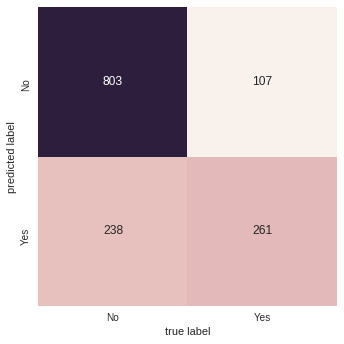

In [0]:
# Confusion Matrix
mat_ann = confusion_matrix(y_test, y_pred)
sns.heatmap(mat_ann.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')

## SVM

In [0]:
svm_classifier= SVC(probability=True)
svm_classifier.fit(X_train,y_train)
svm_prob = svm_classifier.predict_proba(X_test)[:,1]

In [0]:
y_pred_svm[np.where(svm_prob>=0.3)]=1
y_pred_svm[np.where(svm_prob<0.3)]=0
#Classification Report
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1041
           1       0.61      0.54      0.57       368

   micro avg       0.79      0.79      0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



## Logistic Regression

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logis_prob = logreg.predict_proba(X_test)[:,1]
y_pred_logis = np.zeros_like(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
y_pred_logis[np.where(logis_prob>=0.3)]=1
y_pred_logis[np.where(logis_prob<0.3)]=0
#Classification Report
print(classification_report(y_test,y_pred_logis))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1041
           1       0.50      0.77      0.61       368

   micro avg       0.74      0.74      0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

